##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/video/video_classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/video/video_classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/video/video_classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/video/video_classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

# 使用 3D 卷积神经网络 (CNN) 进行视频分类

本教程演示了如何使用 [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) 动作识别数据集训练一个用于视频分类的 3D 卷积神经网络。3D CNN 使用三维过滤器来执行卷积。内核能够在三个维度上滑动，而在 2D CNN 中，它可以在两个维度上滑动。此模型基于 D. Tran 等人在 [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3)（2017 年）中发表的工作。在本教程中，您将完成以下任务：

- 构建输入流水线
- 使用 Keras 函数式 API 构建具有残差连接的 3D 卷积神经网络模型
- 训练模型
- 评估和测试模型

本视频分类教程是 TensorFlow 视频教程系列的第二部分。下面是其他三个教程：

- [加载视频数据](https://tensorflow.google.cn/tutorials/load_data/video)：本教程解释了本文档中使用的大部分代码。
- [用于流式动作识别的 MoViNet](https://tensorflow.google.cn/hub/tutorials/movinet)：熟悉 TF Hub 上提供的 MoViNet 模型。
- [使用 MoViNet 进行视频分类的迁移学习](https://tensorflow.google.cn/tutorials/video/transfer_learning_with_movinet)：本教程介绍了如何使用预训练的视频分类模型，该模型是在具有 UCF-101 数据集的不同数据集上训练的。

## 安装

首先，安装和导入一些必要的库，包括：用于检查 ZIP 文件内容的 [remotezip](https://github.com/gtsystem/python-remotezip)，用于使用进度条的 [tqdm](https://github.com/tqdm/tqdm)，用于处理视频文件的 [OpenCV](https://opencv.org/)，用于执行更复杂张量运算的 [einops](https://github.com/arogozhnikov/einops/tree/master/docs)，以及用于在 Jupyter 笔记本中嵌入数据的 [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs)。

注：使用 TensorFlow 2.10 运行本教程。TensorFlow 2.10 以上的版本可能无法成功运行。

In [2]:
!pip install remotezip tqdm opencv-python einops

In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


## 加载并预处理视频数据

下面的隐藏单元定义了从 UCF-101 数据集下载数据切片并将其加载到 `tf.data.Dataset` 中的函数。可以在[加载视频数据教程](../load_data/video.ipynb)中详细了解特定的预处理步骤，此教程将更详细地介绍此代码。

隐藏块末尾的 `FrameGenerator` 类是这里最重要的实用工具。它会创建一个可以将数据馈送到 TensorFlow 数据流水线中的可迭代对象。具体来说，此类包含一个可加载视频帧及其编码标签的 Python 生成器。生成器 (`__call__`) 函数可产生由 `frames_from_video_file` 生成的帧数组以及与帧集关联的标签的独热编码向量。

In [4]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 10,
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [00:36<00:00,  8.12it/s]


val :


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


test :


100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


创建训练集、验证集和测试集（`train_ds`、`val_ds` 和 `test_ds`）。

In [6]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training = True),
                                          output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(8)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)
val_ds = val_ds.batch(8)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                         output_signature = output_signature)

test_ds = test_ds.batch(8)

## 创建模型

以下 3D 卷积神经网络模型基于 D. Tran 等人的论文 [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3)（2017 年）。这篇论文比较了数个版本的 3D ResNet。与标准 ResNet 一样，它们并非对具有维度 `(height, width)` 的单个图像进行运算，而是对视频体积 `(time, height, width)` 进行运算。解决这一问题的最明显方式是将每个 2D 卷积 (`layers.Conv2D`) 替换为 3D 卷积 (`layers.Conv3D`)。

本教程使用具有[残差连接](https://arxiv.org/abs/1512.03385)的 (2 + 1)D 卷积。(2 + 1)D 卷积允许对空间和时间维度进行分解，进而创建两个单独的步骤。这种方式的一个优势在于，将卷积因式分解为空间和时间维度有助于节省参数。

对于每个输出位置，3D 卷积将体积的 3D 补丁中的所有向量组合在一起，以在输出体积中创建一个向量。

![3D 卷积](https://tensorflow.google.cn/images/tutorials/video/3DCNN.png)

此运算需要 `time * height * width * channels` 个输入并产生 `channels` 个输出（假设输入和输出通道的数量相同。这样，内核大小为 `(3 x 3 x 3)` 的 3D 卷积层需要一个具有 `27 * channels ** 2` 个条目的权重矩阵。根据参考论文的发现，更有效且高效的方式是对卷积进行因式分解。他们提出了一个 (2+1)D 卷积来分别处理空间和时间维度，而不是用单个 3D 卷积来处理时间和空间维度。下图显示了一个 (2 + 1)D 卷积因式分解后的空间和时间卷积。

![(2+1)D 卷积](https://tensorflow.google.cn/images/tutorials/video/2plus1CNN.png)

这种方式的主要优点是减少了参数数量。在 (2 + 1)D 卷积中，空间卷积接受形状为 `(1, width, height)` 的数据，而时间卷积接受形状为 `(time, 1, 1)` 的数据。例如，内核大小为 `(3 x 3 x 3)` 的 (2 + 1)D 卷积需要大小为 `(9 * channels**2) + (3 * channels**2)` 的权重矩阵，不到完整 3D 卷积的一半。本教程实现了 (2 + 1)D ResNet18，其中 ResNet 中的每个卷积都被替换为 (2+1)D 卷积。

In [7]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [8]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

ResNet 模型由一系列残差块组成。一个残差块有两个分支。主分支执行计算，但难以让梯度流过。残差分支绕过主计算，大部分只是将输入添加到主分支的输出中。梯度很容易流过此分支。因此，将存在从损失函数到任何残差块的主分支的简单路径。这有助于避免梯度消失的问题。

使用以下类创建残差块的主分支。与标准 ResNet 结构相比，它使用自定义的 `Conv2Plus1D` 层而不是 `layers.Conv2D`。

In [9]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

要将残差分支添加到主分支，它需要具有相同的大小。下面的 `Project` 层处理分支上通道数发生变化的情况。特别是，添加了一系列密集连接层，然后添加了归一化。

In [10]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

使用 `add_residual_block` 在模型的各层之间引入跳跃连接。

In [11]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

必须调整视频大小才能执行数据的下采样。特别是，对视频帧进行下采样允许模型检查帧的特定部分，以检测可能特定于某个动作的模式。通过下采样，可以丢弃非必要信息。此外，调整视频大小将允许降维，从而加快模型的处理速度。

In [12]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

使用 [Keras 函数式 API](https://tensorflow.google.cn/guide/keras/functional) 构建残差网络。

In [13]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

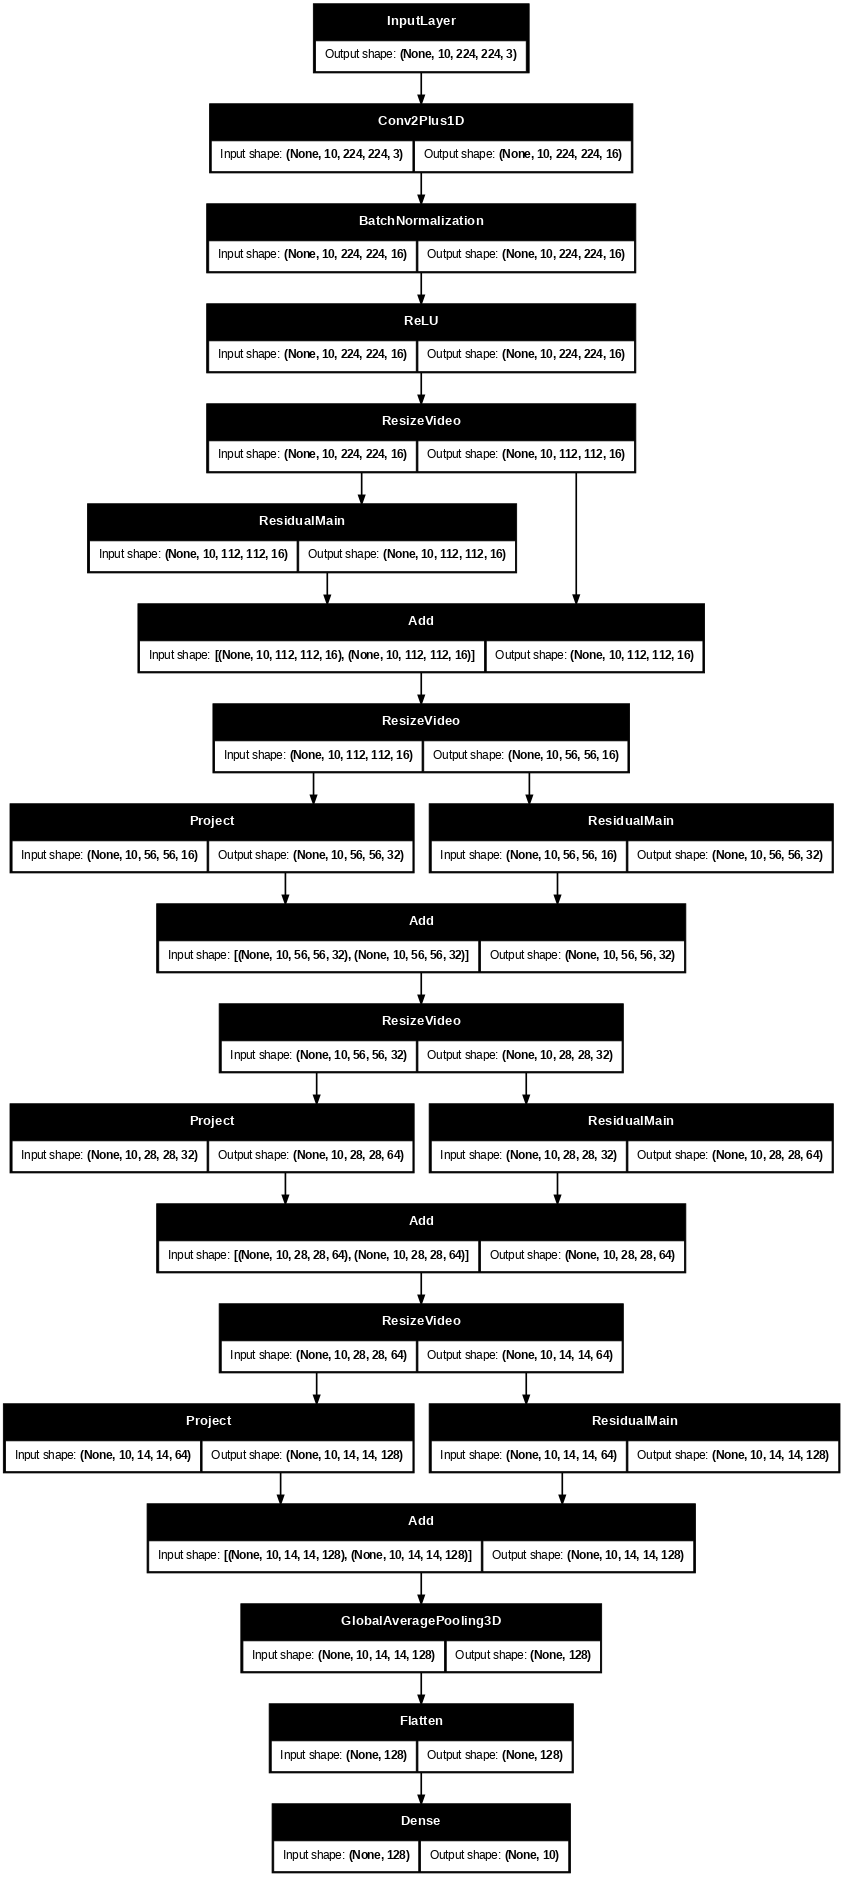

In [15]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## 训练模型

对于本教程，选择 `tf.keras.optimizers.Adam` 优化器和 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数。使用 `metrics` 参数查看每个步骤中模型性能的准确率。

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

使用 Keras `Model.fit` 方法将模型训练 50 个周期。

注：此示例模型在较少的数据点（300 个训练样本和 100 个验证样本）上进行训练，以保持本教程具有合理的训练时间。此外，此示例模型可能需要超过一个小时来训练。

In [17]:
# history = model.fit(x = train_ds,
#                     epochs = 50,
#                     validation_data = val_ds)

Epoch 1/50
     38/Unknown 88s 1s/step - accuracy: 0.1689 - loss: 2.6046

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1679 - loss: 2.6013 - val_accuracy: 0.1500 - val_loss: 2.4440
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.1621 - loss: 2.2268 - val_accuracy: 0.1000 - val_loss: 2.1741
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2015 - loss: 2.1237 - val_accuracy: 0.2500 - val_loss: 2.0641
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2265 - loss: 2.0608 - val_accuracy: 0.2300 - val_loss: 2.3087
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3130 - loss: 2.0832 - val_accuracy: 0.2600 - val_loss: 2.1420
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3394 - loss: 1.8627 - val_accuracy: 0.2100 - val_loss: 2.1326
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3323 - loss: 1.7783 - val_accuracy: 0.2400 - val_loss: 2.1971
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3054 - loss: 1.8348 - val_accuracy: 0.2900 - val_loss: 1.8884
Ep

### 呈现结果

在训练集和验证集上创建损失和准确率的图表：

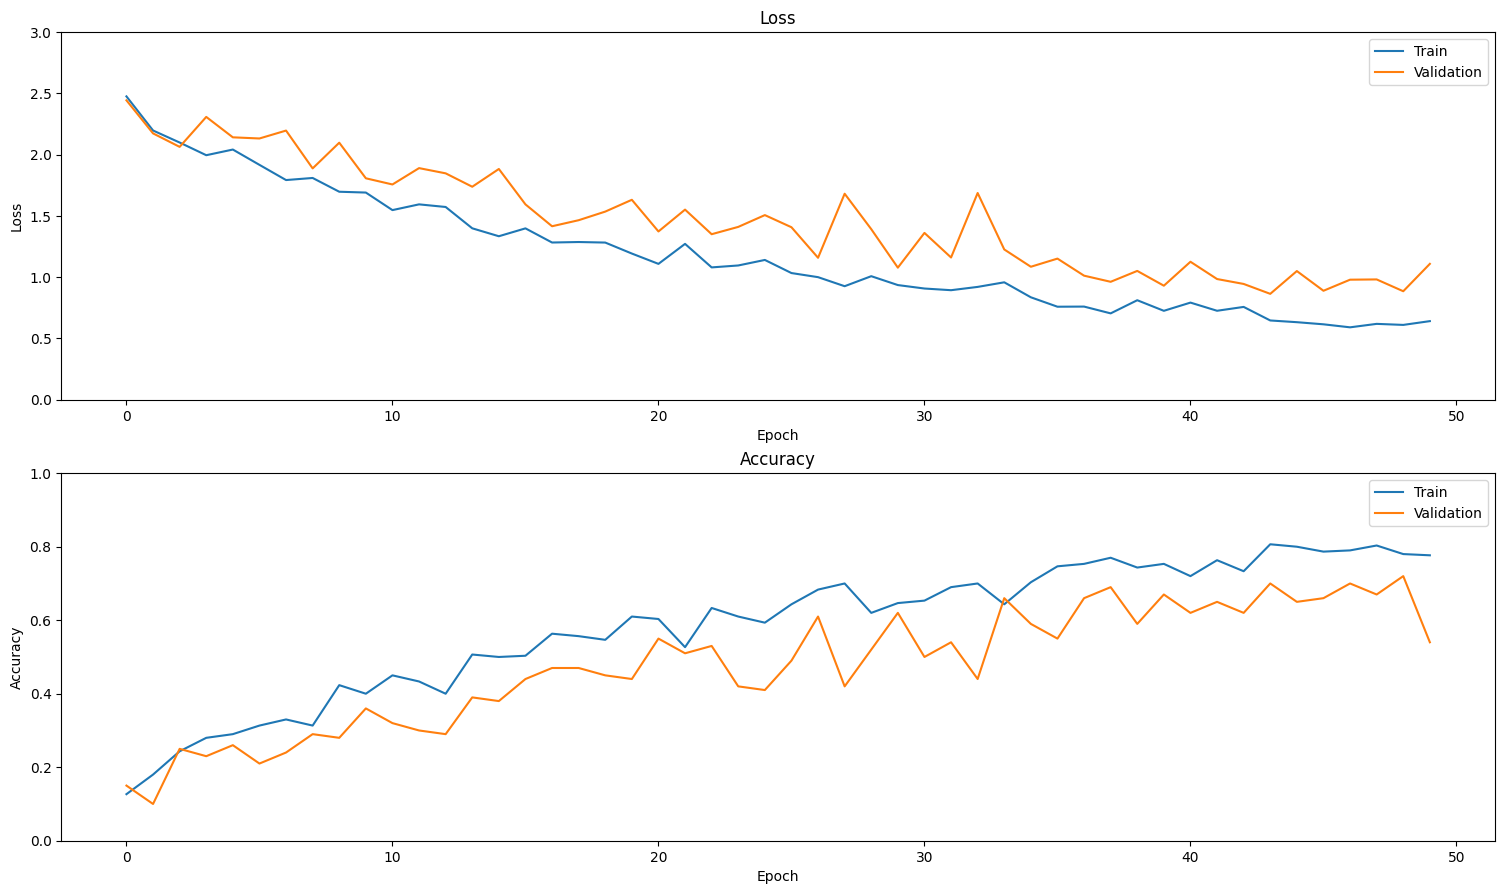

In [18]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## 评估模型

使用 Keras `Model.evaluate` 获取测试数据集的损失和准确率。

注：本教程中的示例模型使用 UCF101 数据集的子集来保持合理的训练时间。通过进一步的超参数调优或更多的训练数据，可以改善准确率和损失。

In [19]:
model.evaluate(test_ds, return_dict = True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 860ms/step - accuracy: 0.5352 - loss: 1.4337


{'accuracy': 0.6200000047683716, 'loss': 1.2978579998016357}

要进一步呈现模型性能，请使用[混淆矩阵](https://tensorflow.google.cn/api_docs/python/tf/math/confusion_matrix)。混淆矩阵允许评估分类模型的性能，而不仅仅是准确率。为了构建此多类分类问题的混淆矩阵，需要获得测试集中的实际值和预测值。

In [20]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [22]:
labels = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam',
          'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress']

38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 935ms/step


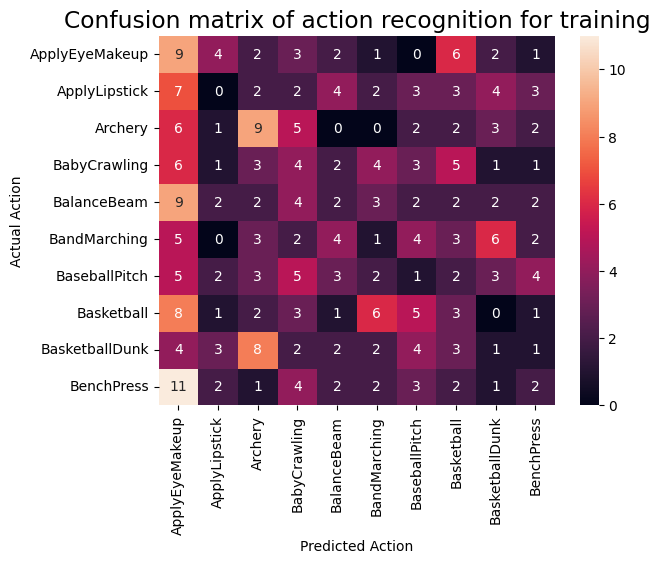

In [23]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 865ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


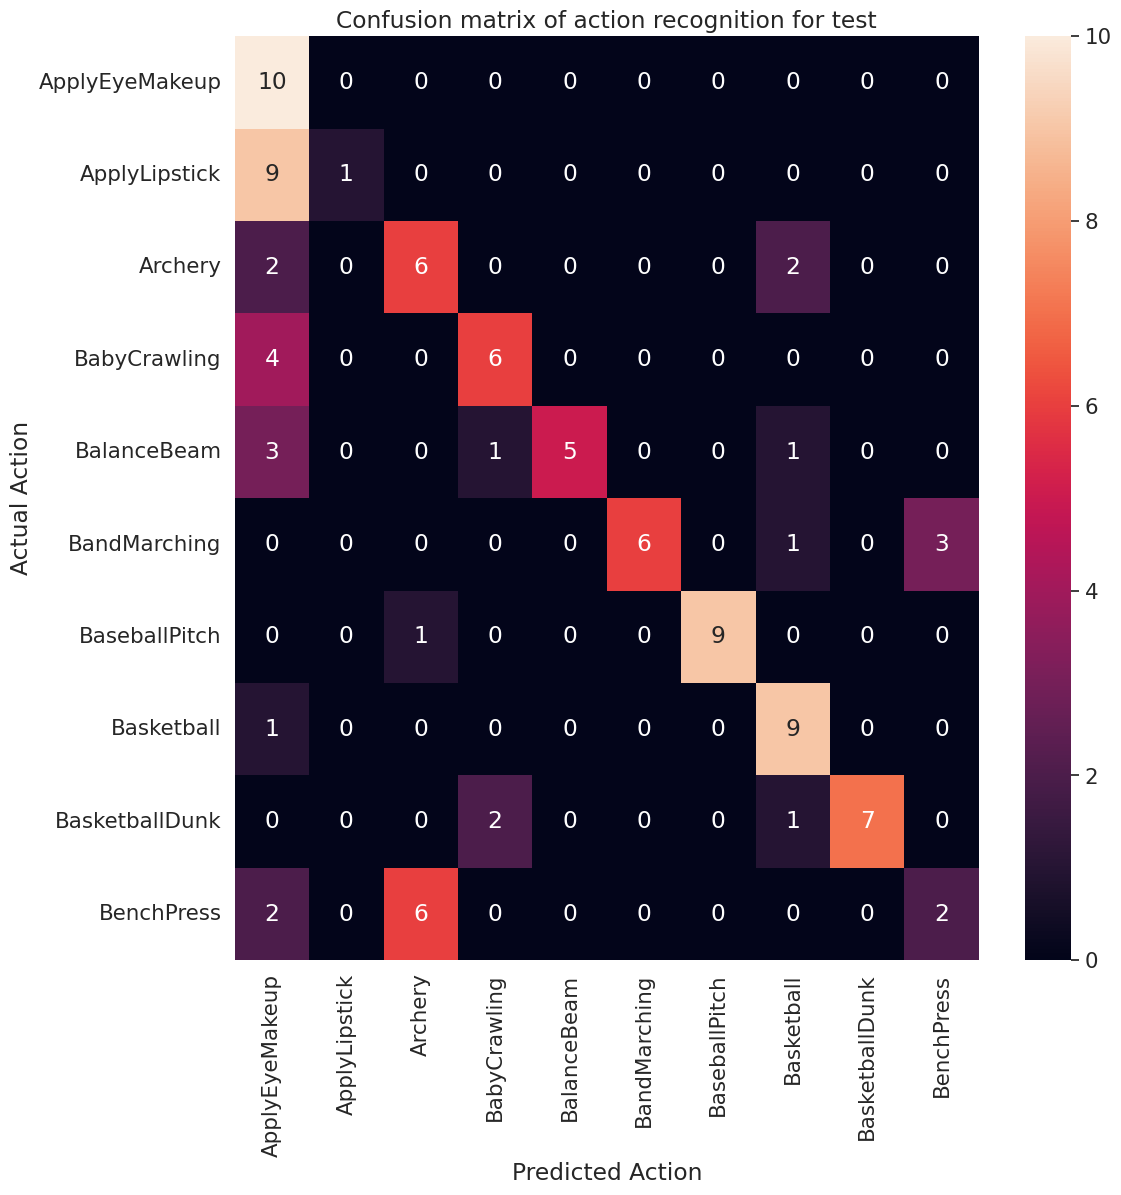

In [24]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

另外，还可以使用混淆矩阵计算每个类的准确率和召回率值。

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [27]:
precision

{'ApplyEyeMakeup': np.float64(0.3225806451612903),
 'ApplyLipstick': np.float64(1.0),
 'Archery': np.float64(0.46153846153846156),
 'BabyCrawling': np.float64(0.6666666666666666),
 'BalanceBeam': np.float64(1.0),
 'BandMarching': np.float64(1.0),
 'BaseballPitch': np.float64(1.0),
 'Basketball': np.float64(0.6428571428571429),
 'BasketballDunk': np.float64(1.0),
 'BenchPress': np.float64(0.4)}

In [28]:
recall

{'ApplyEyeMakeup': np.float64(1.0),
 'ApplyLipstick': np.float64(0.1),
 'Archery': np.float64(0.6),
 'BabyCrawling': np.float64(0.6),
 'BalanceBeam': np.float64(0.5),
 'BandMarching': np.float64(0.6),
 'BaseballPitch': np.float64(0.9),
 'Basketball': np.float64(0.9),
 'BasketballDunk': np.float64(0.7),
 'BenchPress': np.float64(0.2)}

## Next steps

要详细了解如何在 TensorFlow 中处理视频数据，请查看以下教程：

- 加载视频数据
- 用于流式动作识别的 MoViNet
- 使用 MoViNet 进行视频分类的迁移学习